In [1]:
from findkit.index import AnnoyIndex
from findkit.feature_extractor import KerasFeatureExtractor

from sklearn.preprocessing import OneHotEncoder

from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras.datasets import mnist

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Data loading and plotting utils

In [2]:
def plot_image(image_data):
    plt.figure(figsize=(2,2))
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')
    plt.show()
    
    
def images_to_vectors(images):
    return images.reshape(images.shape[0], -1)


def one_hot_encode_labels(train_labels, test_labels):
    ohe = OneHotEncoder()
    ohe_train = ohe.fit_transform(train_labels.reshape(-1, 1))
    ohe_test = ohe.transform(test_labels.reshape(-1, 1))
    return ohe_train, ohe_test

### Keras model setup

In [3]:
def setup_model(n_hidden, input_shape, n_classes, activation='sigmoid'):
    input_tensor = Input(shape=input_shape)

    hid_z = Dense(n_hidden)(input_tensor)
    hid_a = Activation(activation)(hid_z)

    softmax_in = Dense(n_classes)(hid_a)
    mlp_model = Model(inputs=[input_tensor], outputs=[Activation('softmax')(softmax_in)])
    mlp_model.compile(optimizer='adam', loss='categorical_crossentropy')
    return mlp_model

In [4]:
(X_train_images, y_train_labels), (X_test_images, y_test_labels) = mnist.load_data()

X_train = images_to_vectors(X_train_images)
X_test = images_to_vectors(X_test_images)

y_train, y_test = one_hot_encode_labels(y_train_labels, y_test_labels)

### Transformer setup

In [5]:
n_hidden = 64 
input_shape = (X_train.shape[1],)
n_classes = y_train.shape[1]

mlp_model = setup_model(64, input_shape, n_classes)

In [6]:
mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [7]:
mlp_fit_history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    verbose=2
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 0.6764 - val_loss: 0.3958
Epoch 2/10
 - 4s - loss: 0.3870 - val_loss: 0.3448
Epoch 3/10
 - 5s - loss: 0.3337 - val_loss: 0.3183
Epoch 4/10
 - 5s - loss: 0.3157 - val_loss: 0.3106
Epoch 5/10
 - 4s - loss: 0.3045 - val_loss: 0.3043
Epoch 6/10
 - 4s - loss: 0.2949 - val_loss: 0.2909
Epoch 7/10
 - 5s - loss: 0.2879 - val_loss: 0.2835
Epoch 8/10
 - 5s - loss: 0.2877 - val_loss: 0.2864
Epoch 9/10
 - 5s - loss: 0.2817 - val_loss: 0.2858
Epoch 10/10
 - 5s - loss: 0.2703 - val_loss: 0.2695


### Setup feature extractor from transformer

In [8]:
feature_extractor = KerasFeatureExtractor(mlp_model, 'activation_1')

In [9]:
mlp_features = feature_extractor.extract_features(X_test)

### Setup index

In [10]:
index = AnnoyIndex(mlp_features, n_trees=10, metric='euclidean')

### Nearest neighbor query

In [11]:
query_example_index = 0
query_example = mlp_features[query_example_index]
n_neighbors = 10

In [12]:
neighbor_indices, neighbor_distances = index.find_similar(query_example, n_neighbors+1)

Queried example


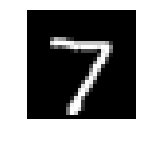

0th closest image
distance from query image: 0.003


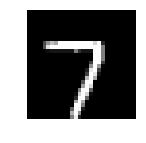

1th closest image
distance from query image: 0.003


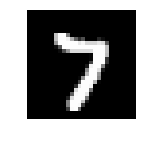

2th closest image
distance from query image: 0.003


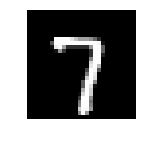

3th closest image
distance from query image: 0.003


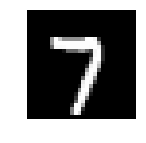

4th closest image
distance from query image: 0.003


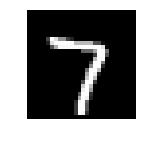

5th closest image
distance from query image: 0.003


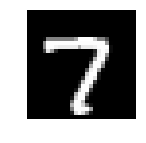

6th closest image
distance from query image: 0.003


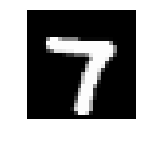

7th closest image
distance from query image: 0.003


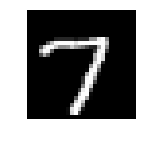

8th closest image
distance from query image: 0.164


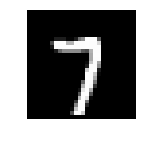

9th closest image
distance from query image: 0.988


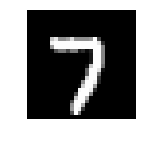

In [13]:
print('Queried example')
plot_image(X_test_images[query_example_index])

# drop first example (it is the same as query example)
truncated_results = zip(neighbor_indices[1:], neighbor_distances[1:])

for i, (neighbor_index, distance) in enumerate(truncated_results):
    print('{}th closest image'.format(i))
    print('distance from query image: {:.3f}'.format(distance))
    plot_image(X_test_images[neighbor_index])